In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 中债国债收益率曲线.xls to 中债国债收益率曲线.xls


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import tensorflow as tf
from keras import backend as K
import io
from google.colab import files
import random

In [ ]:
# 读取并处理中债国债收益率曲线数据，由于40及50年期限国债到期收益率从2009年11月30日之前数据缺失，所以分开处理
# 分开后的数据整体完整，去掉NA数据并不影响分析结果
national_debt = pd.read_excel(io.BytesIO(uploaded['中债国债收益率曲线.xls']), parse_dates=True)
national_debt = national_debt.iloc[1:(national_debt.shape[0]-2),1:]
national_debt_s = national_debt.iloc[:,:national_debt.shape[1]-2].dropna()
national_debt_l = national_debt.iloc[:,national_debt.shape[1]-2:].dropna()

In [ ]:
#national_debt.head(30)

In [ ]:
# 数据预处理：需要建立训练集和测试集。训练集的输入为前n天的利率，输出为第二天的数据；测试集一样
# 首先定义一个类，调用此类可以将数据自动分为训练集和测试集，并分出输入数据与输出数据
class DataProcessing:
    def __init__(self, file, train):
        self.file = file                                # 读取数据
        self.train = train                              # 训练集所占比例     
        self.i = int(self.train * len(self.file))       # 训练集大小（具体数字）
        self.stock_train = self.file[0: self.i]         # 得到训练集
        self.stock_test = self.file[self.i:]            # 得到测试集
        self.input_train = []
        self.output_train = []
        self.input_test = []
        self.output_test = []

    def gen_train(self, seq_len):
        """
        Generates training data
        :param seq_len: length of window
        :return: X_train and Y_train
        """
        for i in range((len(self.stock_train)//seq_len)*seq_len - seq_len - 1):
            x = np.array(self.stock_train.iloc[i: i + seq_len])
            y = np.array([self.stock_train.iloc[i + seq_len]], np.float64)
            self.input_train.append(x)
            self.output_train.append(y)
        self.X_train = np.array(self.input_train)
        self.Y_train = np.array(self.output_train)

    def gen_test(self, seq_len):
        """
        Generates test data
        :param seq_len: Length of window
        :return: X_test and Y_test
        """
        for i in range((len(self.stock_test)//seq_len)*seq_len - seq_len - 1):
            x = np.array(self.stock_test.iloc[i: i + seq_len], np.float64)
            y = np.array([self.stock_test.iloc[i + seq_len]], np.float64)
            self.input_test.append(x)
            self.output_test.append(y)
        self.X_test = np.array(self.input_test)
        self.Y_test = np.array(self.output_test)

In [ ]:
data = national_debt_s.iloc[:,15]
p = 0.8
n = 50
e = 100
process_data = DataProcessing(data, p)
process_data.gen_test(n)
process_data.gen_train(n)
      
# reshape训练集和测试集，用来建立模型
r_train = int((len(data)*p//n)*n - n - 1)
r_test = int((len(data)*(1-p)//n)*n - n - 1)
x_train = process_data.X_train.reshape((r_train,n,1))*10
y_train = process_data.Y_train.reshape((r_train,1,1))*10
x_test = process_data.X_test.reshape((r_test,n,1))*10
y_test = process_data.Y_test.reshape((r_test,1,1))*10
      
# 将数据转化成可用于 Tensorflow 使用的 float 形式：
x_train = K.cast_to_floatx(x_train)
y_train = K.cast_to_floatx(y_train)
x_test = K.cast_to_floatx(x_test)
y_test = K.cast_to_floatx(y_test)

### 建立一个callback的class：
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.83):
      print('\nLoss is low so cancelling training!')
      self.model.stop_training = True
callbacks = myCallback()

# 建立 LSTM 模型：
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(50, input_shape=(n, 1), return_sequences=True))
#lstm_model.add(tf.keras.layers.Dropout(0.2))
lstm_model.add(tf.keras.layers.LSTM(50, return_sequences=True))
#lstm_model.add(tf.keras.layers.Dropout(0.2))
lstm_model.add(tf.keras.layers.LSTM(50))
lstm_model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))
lstm_model.compile(optimizer="adam", loss="mean_squared_error")
lstm_model.fit(x_train, y_train, epochs=e, callbacks=[callbacks])
#lstm_model.fit(x_test, y_test, epochs=e)
loss = lstm_model.evaluate(x_test, y_test)

Epoch 1/100
115/115 [==============================] - 7s 59ms/step - loss: 799.8981
Epoch 2/100
115/115 [==============================] - 7s 62ms/step - loss: 447.2478
Epoch 3/100
115/115 [==============================] - 7s 61ms/step - loss: 264.9874
Epoch 4/100
115/115 [==============================] - 7s 61ms/step - loss: 156.7356
Epoch 5/100
115/115 [==============================] - 7s 61ms/step - loss: 95.1150
Epoch 6/100
115/115 [==============================] - 7s 62ms/step - loss: 62.3995
Epoch 7/100
115/115 [==============================] - 7s 63ms/step - loss: 46.3543
Epoch 8/100
115/115 [==============================] - 7s 63ms/step - loss: 39.3483
Epoch 9/100
115/115 [==============================] - 7s 62ms/step - loss: 36.4433
Epoch 10/100
115/115 [==============================] - 7s 62ms/step - loss: 35.4564
Epoch 11/100
115/115 [==============================] - 7s 63ms/step - loss: 35.1660
Epoch 12/100
115/115 [==============================] - 7s 63ms/step -

In [ ]:
test_predict = lstm_model.predict(x_test)/10
b = pd.DataFrame(test_predict)

In [ ]:
test_y = pd.DataFrame(((y_test/10)).reshape(849,1).tolist())

In [ ]:
from scipy import stats
stats.ttest_ind(test_predict, test_y)

Ttest_indResult(statistic=array([-0.92036925]), pvalue=array([0.35751072]))

No handles with labels found to put in legend.


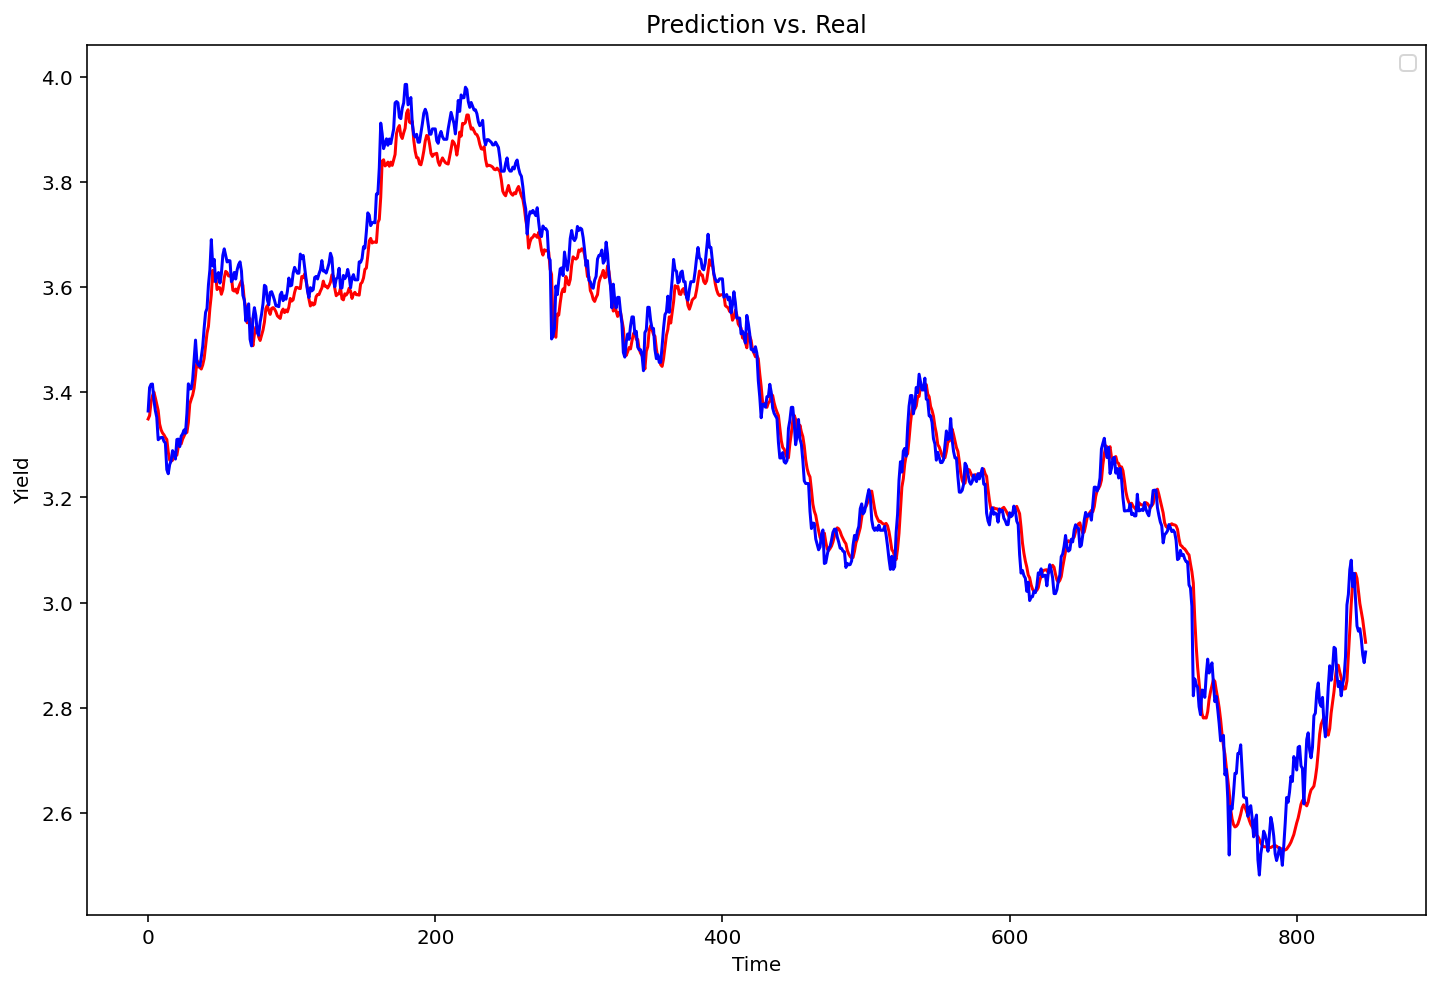

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(b, color='red')
plt.plot(test_y, color='blue')
plt.title('Prediction vs. Real')
plt.xlabel('Time')
plt.ylabel('Yield')
plt.legend();

In [ ]:
# 定义一个用于预测的方程：
def lets_predict(data, t, n):     # t 为想要预测的未来时间段，p 为训练集比例（用小数表示，默认值为0.8)，
                                  # n 为输入变量的个数，此处的输入变量为过去 n 天利率
    
    i = 1
    result = []
    data1 = (data[-n:]).values.tolist()
    while i <= t:
      x_predict = np.array(data1).reshape((1,n,1))*10
      x_predict = K.cast_to_floatx(x_predict)
      data_predict = lstm_model.predict(x_predict)/10
      data_predict = float(data_predict)
      #print(data_predict)
      result.append(data_predict)
      data1.append(data_predict)
      data1 = data1[-n:]
      i += 1
    return pd.DataFrame(result)

In [ ]:
d = lets_predict(data=data, t=100, n=50)

In [ ]:
a = (national_debt_s.iloc[-50:,15]).values.tolist()
x_predict = np.array(a).reshape((1,n,1))*10
x_predict = K.cast_to_floatx(x_predict)
s = lstm_model(x_predict)/10